# 测试 OpenTopography 点云数据

先使用一下 USGS 3DEP Lidar public dataset

In [13]:
import json
import pdal

pipeline_json = {
    "pipeline": [
        {
            "type": "readers.ept",
            "filename": "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json",
            "bounds": "([-10425171.94, -10423171.94], [5164494.71, 5166494.71])"
        },
        {
            "type": "filters.range",
            "limits": "Classification[1:1]"  # 只要分类为 2（通常是地面点）
        }
    ]
}


pipe = pdal.Pipeline(json.dumps(pipeline_json))
count = pipe.execute()

arr = pipe.arrays[0]
count, arr.dtype, arr.shape


(444144,
 dtype([('Classification', 'u1'), ('EdgeOfFlightLine', 'u1'), ('GpsTime', '<f8'), ('Intensity', '<u2'), ('KeyPoint', 'u1'), ('NumberOfReturns', 'u1'), ('OriginId', '<u4'), ('Overlap', 'u1'), ('PointSourceId', '<u2'), ('ReturnNumber', 'u1'), ('ScanAngleRank', '<f4'), ('ScanDirectionFlag', 'u1'), ('Synthetic', 'u1'), ('UserData', 'u1'), ('Withheld', 'u1'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]),
 (444144,))

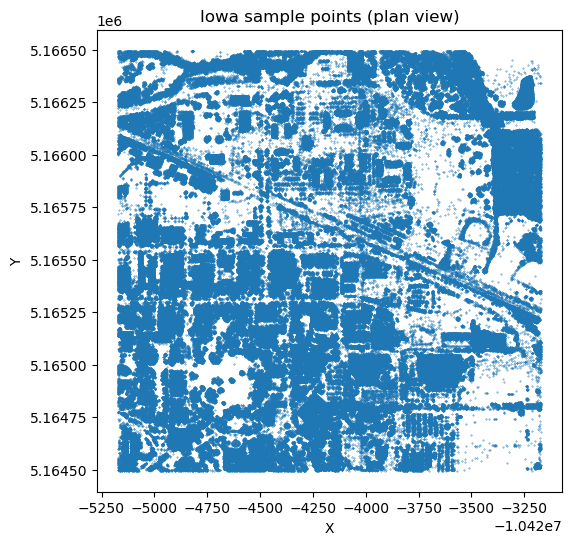

In [2]:
import matplotlib.pyplot as plt

# 通常 PDAL EPT reader 会给出 X/Y/Z 或 x/y/z 之类字段
xs = arr['X']
ys = arr['Y']

plt.figure(figsize=(6, 6))
plt.scatter(xs, ys, s=0.1)
plt.title("Iowa sample points (plan view)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [3]:
arr

array([(1, 0, 56170.49998399,  18, 0, 1, 17583, 0, 85, 1,  6., 1, 0, 69, 0, -10424738.04, 5165423.95, 290.73),
       (1, 0, 56170.49999415,  32, 0, 2, 17583, 0, 85, 1,  6., 1, 0, 69, 0, -10424740.57, 5165424.08, 294.23),
       (1, 0, 56170.51380755,  19, 0, 1, 17583, 0, 85, 1,  6., 0, 0, 69, 0, -10424750.6 , 5165424.09, 294.86),
       ...,
       (1, 0, 55116.491362  ,   6, 0, 3, 17583, 0, 79, 1, -4., 0, 0, 70, 0, -10423319.97, 5166108.52, 286.6 ),
       (1, 0, 55116.50499243,  10, 0, 3, 17583, 0, 79, 2, -4., 1, 0, 70, 0, -10423321.34, 5166109.27, 278.12),
       (1, 0, 55116.51889735, 105, 0, 1, 17583, 0, 79, 1, -4., 0, 0, 70, 0, -10423317.04, 5166111.4 , 273.89)],
      shape=(444144,), dtype=[('Classification', 'u1'), ('EdgeOfFlightLine', 'u1'), ('GpsTime', '<f8'), ('Intensity', '<u2'), ('KeyPoint', 'u1'), ('NumberOfReturns', 'u1'), ('OriginId', '<u4'), ('Overlap', 'u1'), ('PointSourceId', '<u2'), ('ReturnNumber', 'u1'), ('ScanAngleRank', '<f4'), ('ScanDirectionFlag', 'u1'), ('S

In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 假设 arr 还是 PDAL 读出来的那个 numpy structured array
print(arr.dtype.names)  # 看看是不是 'X','Y','Z'

df = pd.DataFrame({
    "x": arr["X"],
    "y": arr["Y"],
    "z": arr["Z"],
})

# 关键 1：这里先按点云原始坐标系来建几何
# USGS EPT 示例用的是 Web Mercator（EPSG:3857），坐标单位是米
geom = gpd.points_from_xy(df["x"], df["y"], df["z"])
gdf = gpd.GeoDataFrame(df, geometry=geom, crs="EPSG:3857")

gdf.head(), gdf.crs


('Classification', 'EdgeOfFlightLine', 'GpsTime', 'Intensity', 'KeyPoint', 'NumberOfReturns', 'OriginId', 'Overlap', 'PointSourceId', 'ReturnNumber', 'ScanAngleRank', 'ScanDirectionFlag', 'Synthetic', 'UserData', 'Withheld', 'X', 'Y', 'Z')


(             x           y       z                                  geometry
 0 -10424738.04  5165423.95  290.73  POINT Z (-10424738.04 5165423.95 290.73)
 1 -10424740.57  5165424.08  294.23  POINT Z (-10424740.57 5165424.08 294.23)
 2 -10424750.60  5165424.09  294.86   POINT Z (-10424750.6 5165424.09 294.86)
 3 -10424743.27  5165421.69  294.99  POINT Z (-10424743.27 5165421.69 294.99)
 4 -10424745.72  5165422.01  294.92  POINT Z (-10424745.72 5165422.01 294.92),
 <Projected CRS: EPSG:3857>
 Name: WGS 84 / Pseudo-Mercator
 Axis Info [cartesian]:
 - X[east]: Easting (metre)
 - Y[north]: Northing (metre)
 Area of Use:
 - name: World between 85.06°S and 85.06°N.
 - bounds: (-180.0, -85.06, 180.0, 85.06)
 Coordinate Operation:
 - name: Popular Visualisation Pseudo-Mercator
 - method: Popular Visualisation Pseudo Mercator
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [5]:
# 关键 2：投影到经纬度
gdf_ll = gdf.to_crs(epsg=4326)  # lon/lat

gdf_ll.head(), gdf_ll.crs


(             x           y       z                             geometry
 0 -10424738.04  5165423.95  290.73  POINT Z (-93.64702 42.02966 290.73)
 1 -10424740.57  5165424.08  294.23  POINT Z (-93.64704 42.02966 294.23)
 2 -10424750.60  5165424.09  294.86  POINT Z (-93.64713 42.02966 294.86)
 3 -10424743.27  5165421.69  294.99  POINT Z (-93.64706 42.02965 294.99)
 4 -10424745.72  5165422.01  294.92  POINT Z (-93.64708 42.02965 294.92),
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [6]:
gdf_vis_ll = gdf_ll[["x", "y", "z", "geometry"]].copy()


In [7]:
from lonboard import Map, PointCloudLayer

# 保留 10% 的点
sample_rate = 10
gdf_small = gdf_ll.iloc[::sample_rate].copy()
gdf_small


layer = PointCloudLayer.from_geopandas(
    gdf_small,
    auto_downcast=False,           # 先保持关掉，防止再碰到 ArrowDtype 那个坑
    get_color=[0, 128, 255, 200],  # 统一颜色
    point_size=1,                # 如果这行报错就先注释掉
)


In [8]:
center = gdf_vis_ll.geometry.union_all().centroid
view_state = {
    "longitude": float(center.x),
    "latitude": float(center.y),
    "zoom": 15,
    "pitch": 60,
    "bearing": 0,
}

m = Map(layer, view_state=view_state, height=600, use_device_pixels=False)
m
